# REDES NUERONALES RECURRENTES

Implementacion con un set de señales trigonometricas.

## Funciones comunes a todas la partes

In [63]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [64]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [65]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  # si tengo profundida de mi serie temporal, me quedo solamente con la 1ra.
  series = series[:,:,0]
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [66]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [67]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")

        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader, reduced=0):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X[:,reduced:,:]
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [68]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad:
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()
  print('-'*84)
  print('NRO TOTAL DE PARAMETROS:')
  t_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(t_params)
  print('-'*84)

## Generación de serie de datos y visualización

In [69]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


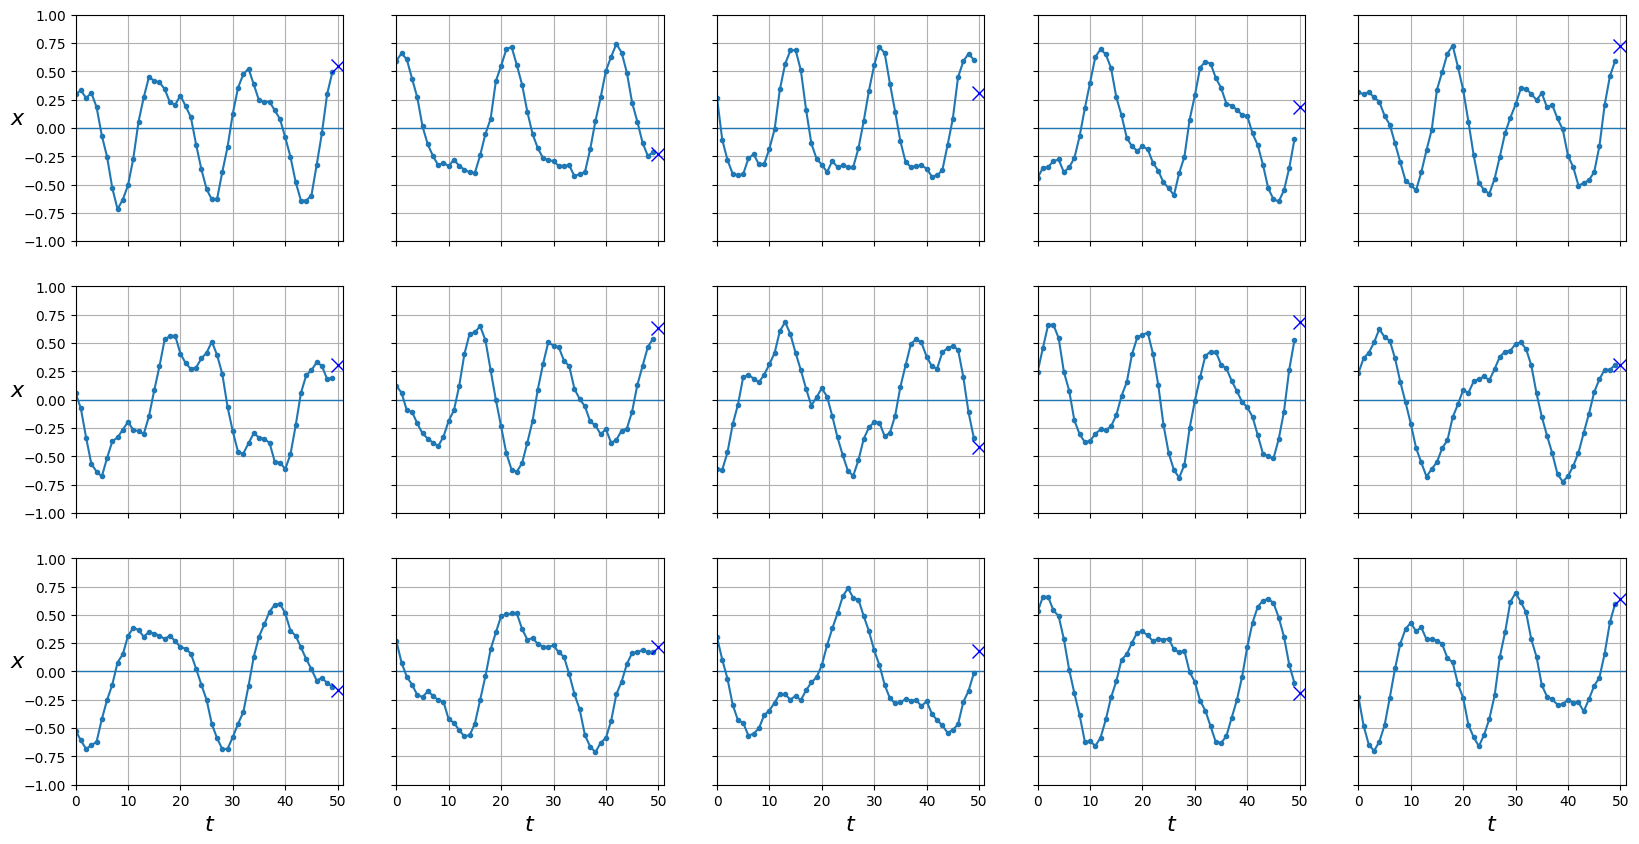

In [70]:
plot_series(X_test, y_test)

In [71]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

## MLP para comparar luego con RNN

In [72]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [73]:
fit(mlp, dataloader)

epoch numero:  0


valid_loss 0.04478: 100%|██████████| 32/32 [00:00<00:00, 255.28it/s]


epoch numero:  1


valid_loss 0.02767: 100%|██████████| 32/32 [00:00<00:00, 275.65it/s]


epoch numero:  2


valid_loss 0.01954: 100%|██████████| 32/32 [00:00<00:00, 225.88it/s]


epoch numero:  3


valid_loss 0.01495: 100%|██████████| 32/32 [00:00<00:00, 244.98it/s]


epoch numero:  4


valid_loss 0.01250: 100%|██████████| 32/32 [00:00<00:00, 298.45it/s]


epoch numero:  5


valid_loss 0.01071: 100%|██████████| 32/32 [00:00<00:00, 222.05it/s]


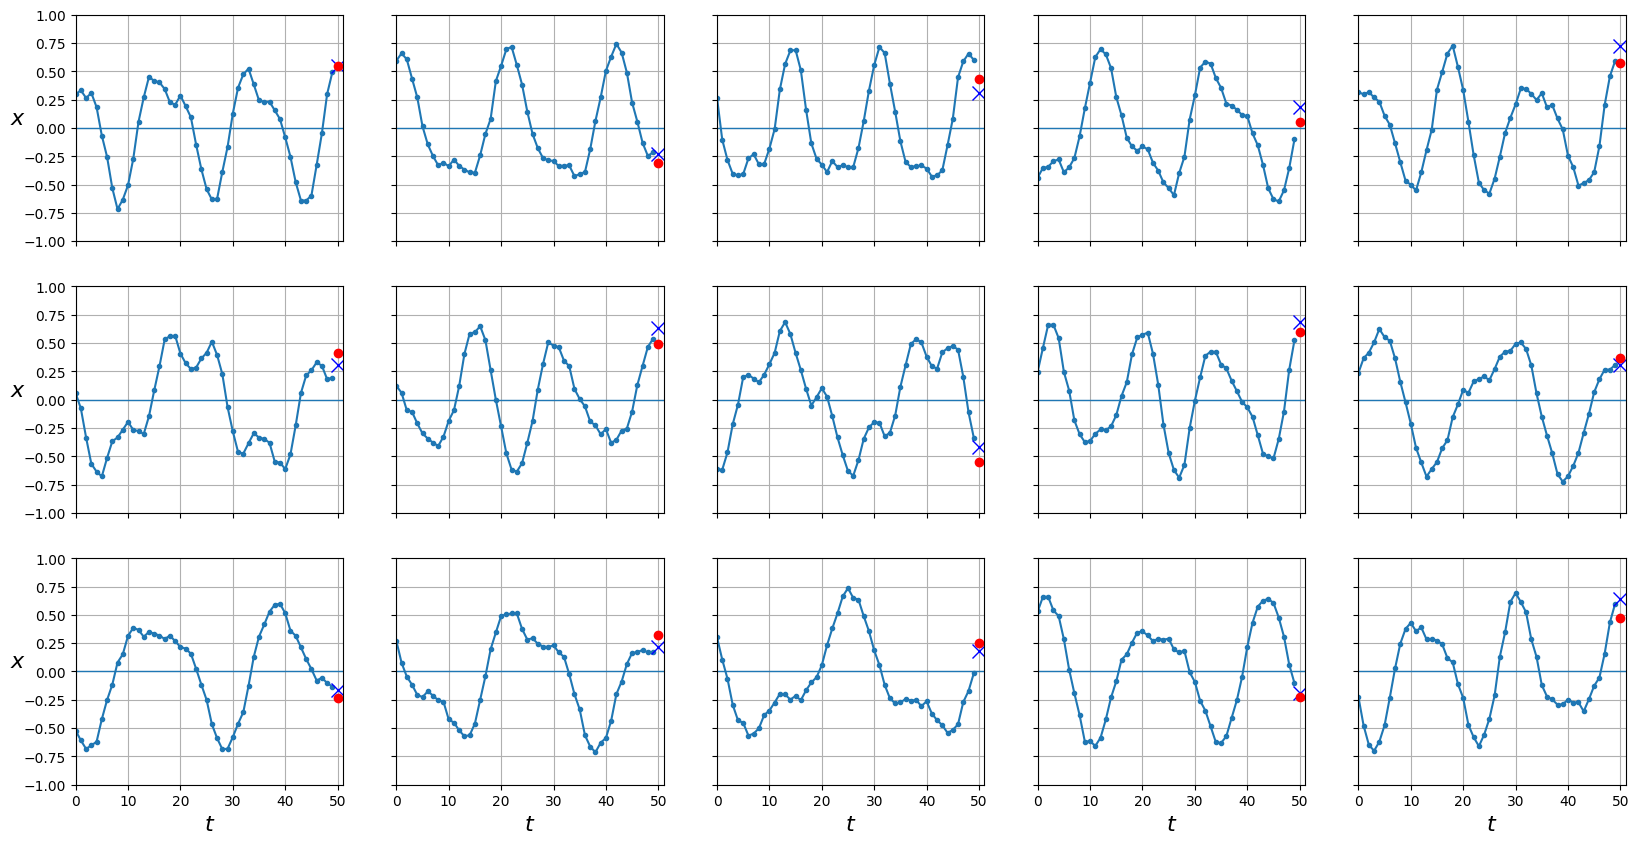

Error cuadratico medio de la estimación final: 


0.010532282

In [74]:
y_pred = predict(mlp, dataloader['test'], reduced=0)
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

## Clase RNN para probar distintas configuraciones.

In [75]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=1, num_layers=1, n_out=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Linear(in_features=hidden_size, out_features=n_out)
    # la fc la colocamos para cuando empleemos mas de 1 neurona hidden, ya que
    # tenemos que combinar todas las hidden de la salida de RNN en 1 solo
    # valor a predecir en el futuro. Para eso usaremos las FC.
    # ver en el forward cómo se leen los valores

  def forward(self, x):
    x, h = self.rnn(x)
    # ATENCION!!
    # La salida tentrá una dimensión del [batch x largo de señal x numero de hidden]
    # y a mi FC solo quiero pasarle la última predicción temporal, de todas sus hidden.
    # por eso, me quedo con:
    #       -- todo el batch
    #       -- solo la última predición temporal
    #       -- de todas sus hidden
    x = self.fc(x[:,-1:,:]) # acá le pasamos las últimas hidden a la FC
    y = torch.squeeze(x, 1) # elimino la dimensión sobrante
    return y



##RNN simple de 1 sola hidden


In [76]:
rnn = RNN(input_size=1, hidden_size=1, num_layers=1)
rnn

RNN(
  (rnn): RNN(1, 1, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=True)
)

In [15]:
# veamos que arroja nuestra rnn

entrada = torch.rand(1, 50, 1)
print('entrada')
print('dimensiones de entrada')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
dimensiones de entrada
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [16]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.5092]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [77]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.96163: 100%|██████████| 32/32 [00:00<00:00, 185.05it/s]


epoch numero:  1


valid_loss 0.69169: 100%|██████████| 32/32 [00:00<00:00, 177.27it/s]


epoch numero:  2


valid_loss 0.46924: 100%|██████████| 32/32 [00:00<00:00, 173.12it/s]


epoch numero:  3


valid_loss 0.35652: 100%|██████████| 32/32 [00:00<00:00, 205.14it/s]


epoch numero:  4


valid_loss 0.33512: 100%|██████████| 32/32 [00:00<00:00, 212.42it/s]


epoch numero:  5


valid_loss 0.33268: 100%|██████████| 32/32 [00:00<00:00, 192.37it/s]


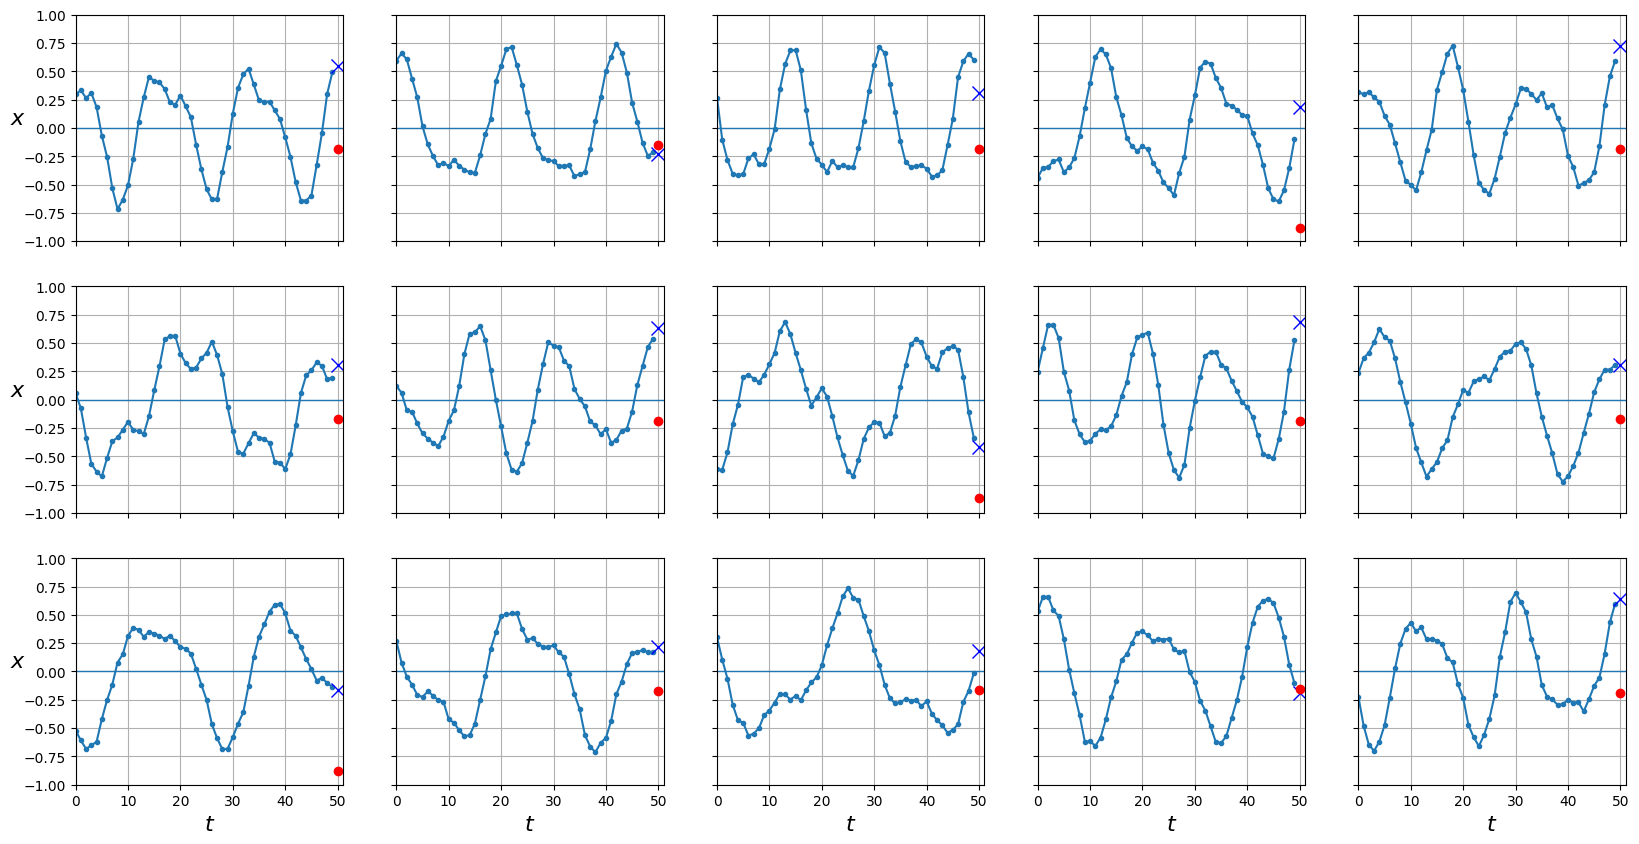

Error cuadratico medio de la estimación final: 


0.37599415

In [78]:
y_pred = predict(rnn, dataloader['test'], reduced=0)
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

### Comparacion de parámetros entre MLP y RNN implementada

In [19]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
51
------------------------------------------------------------------------------------


In [20]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
6
------------------------------------------------------------------------------------


##RNN con mas neuronas hidden.

Aumente el número de neuronas hidden y compare los resultados.

Estudie la cantidad de parámetros de este modelo con los anteriores.

In [79]:
rnn_2 = RNN(input_size=1, hidden_size=30, num_layers=1)
rnn_2

RNN(
  (rnn): RNN(1, 30, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [22]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
6
------------------------------------------------------------------------------------


In [23]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(1, 20, 1)
print('entrada')

print('dimensiones de entrada')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
dimensiones de entrada
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [24]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red:')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red:
tensor([[0.5613]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [80]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.01166: 100%|██████████| 32/32 [00:00<00:00, 117.65it/s]


epoch numero:  1


valid_loss 0.00698: 100%|██████████| 32/32 [00:00<00:00, 82.57it/s]


epoch numero:  2


valid_loss 0.00554: 100%|██████████| 32/32 [00:00<00:00, 167.28it/s]


epoch numero:  3


valid_loss 0.00504: 100%|██████████| 32/32 [00:00<00:00, 170.77it/s]


epoch numero:  4


valid_loss 0.00448: 100%|██████████| 32/32 [00:00<00:00, 170.22it/s]


epoch numero:  5


valid_loss 0.00414: 100%|██████████| 32/32 [00:00<00:00, 167.33it/s]


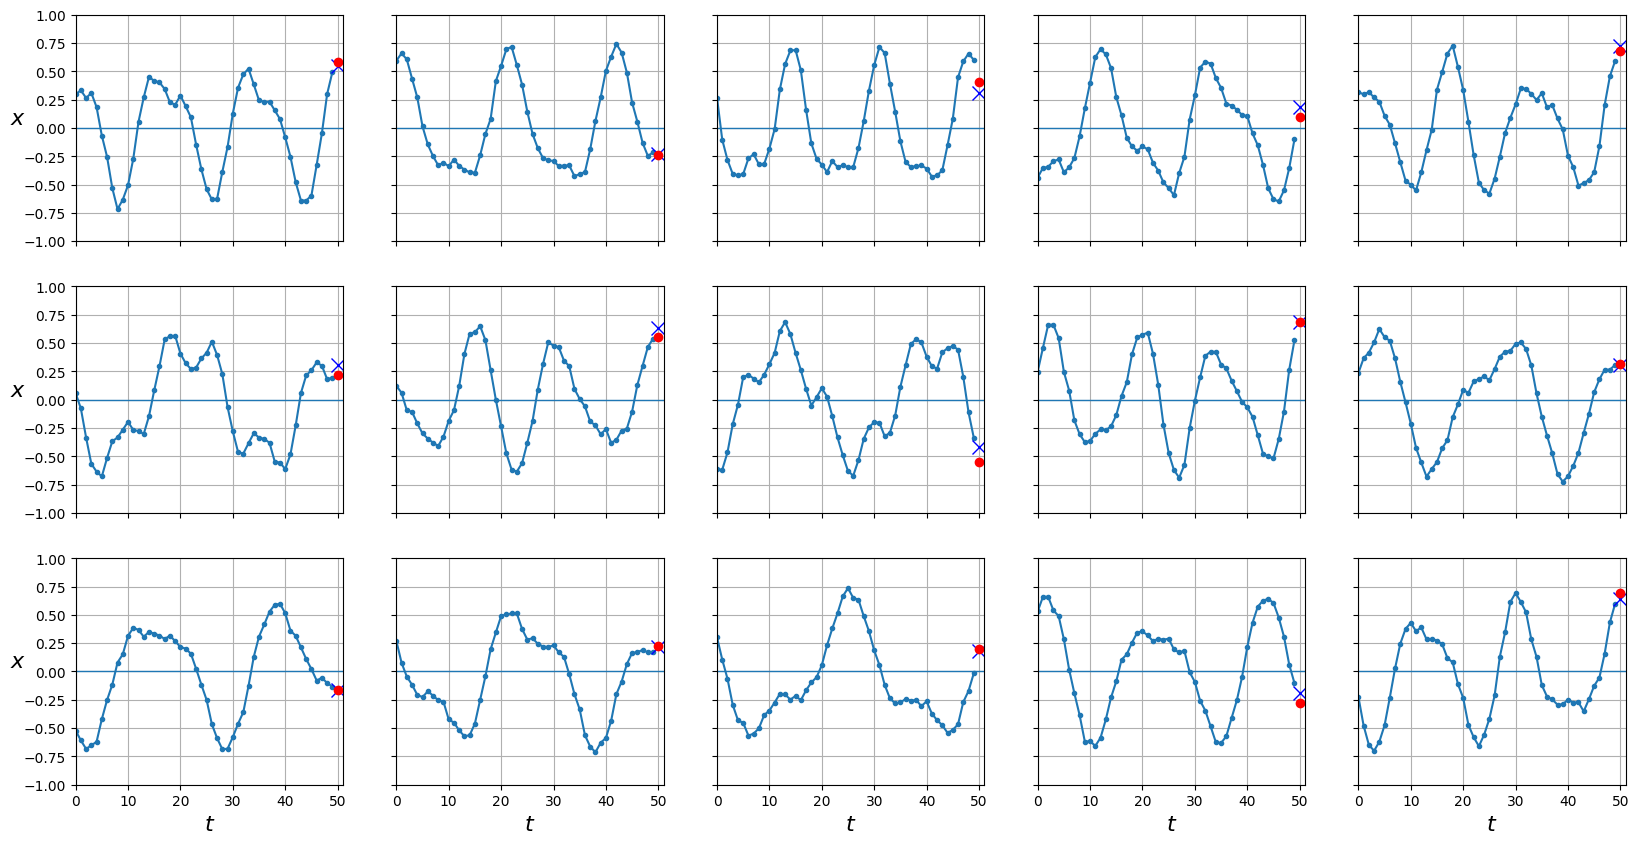

Error cuadratico medio de la estimación final: 


0.0040340843

In [81]:
# la probmos con el test
y_pred = predict(rnn_2, dataloader['test'], reduced=0)
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## RNN con mas layers

Pruebe entrenar un modelo con más layers.





In [82]:
rnn_deep = RNN(input_size=1, hidden_size=5, num_layers=2)
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.11078: 100%|██████████| 32/32 [00:00<00:00, 158.64it/s]


epoch numero:  1


valid_loss 0.05659: 100%|██████████| 32/32 [00:00<00:00, 146.45it/s]


epoch numero:  2


valid_loss 0.02279: 100%|██████████| 32/32 [00:00<00:00, 148.06it/s]


epoch numero:  3


valid_loss 0.01115: 100%|██████████| 32/32 [00:00<00:00, 127.89it/s]


epoch numero:  4


valid_loss 0.00840: 100%|██████████| 32/32 [00:00<00:00, 159.86it/s]


epoch numero:  5


valid_loss 0.00735: 100%|██████████| 32/32 [00:00<00:00, 166.24it/s]


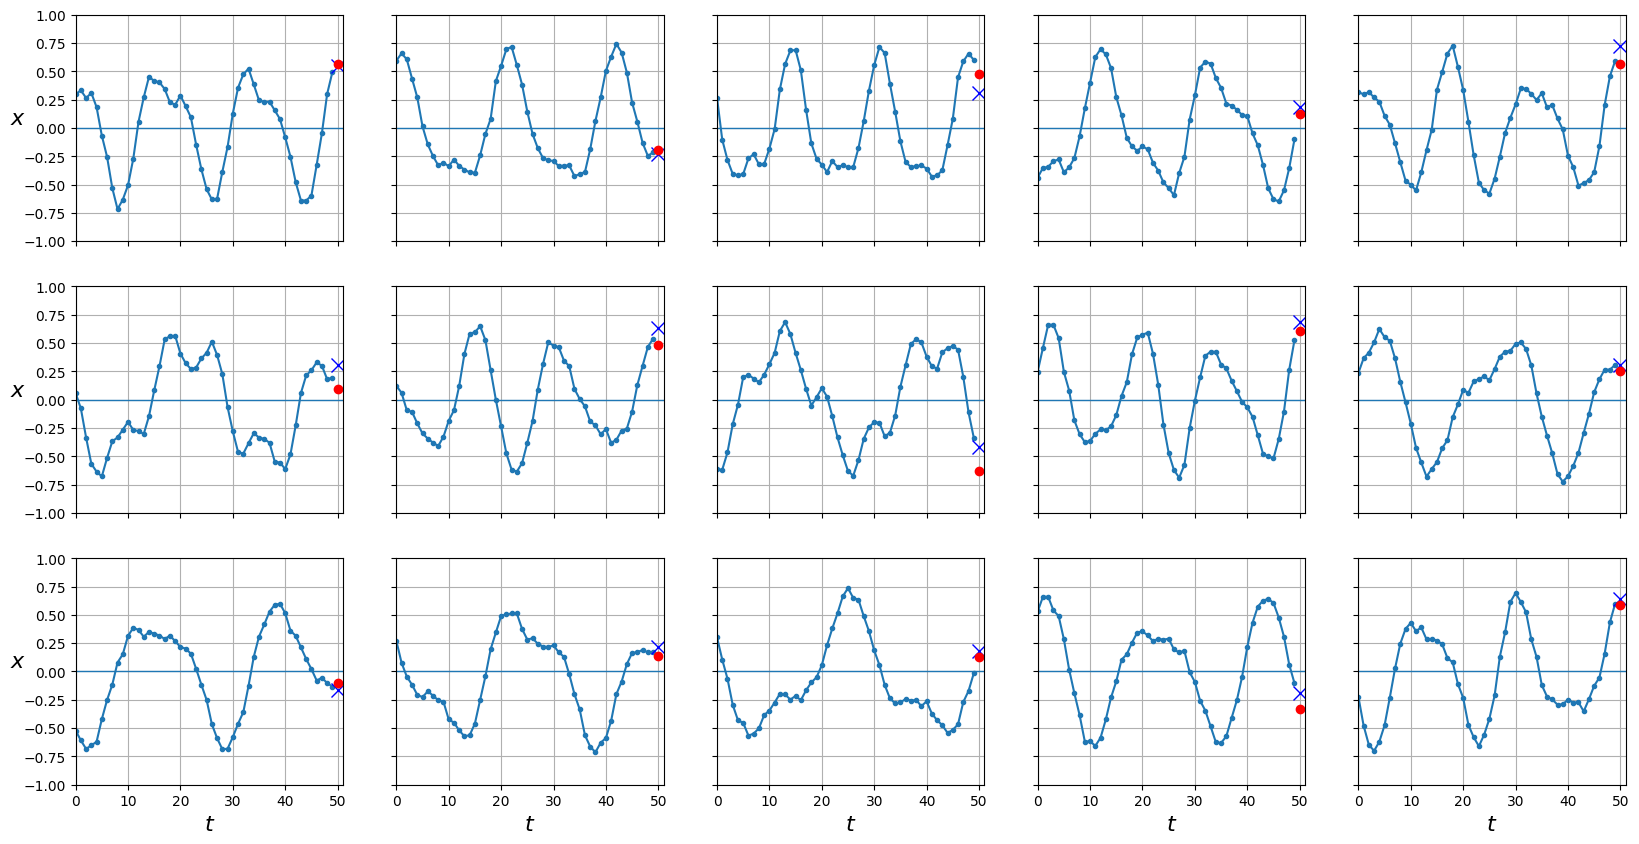

Error cuadratico medio de la estimación final: 


0.007215791

In [83]:
y_pred = predict(rnn_deep, dataloader['test'], reduced = 0)
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

# PROBAR MODIFICAR EL ARGUMENTO REDUCED!!

In [29]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
6
------------------------------------------------------------------------------------


## Por si se quiere graficar 1 sola gráfica

In [88]:
# función que plotea una sola serie (inputs y outputs)
def plot_series2(x, y, y_pred, x_label="$t$", y_label="$x$"):
  #x = np.squeeze(x)
  #y = np.squeeze(y)
  y_pred = np.squeeze(y_pred)
  plt.plot( x, ".-")
  plt.plot(range(len(x), len(x)+len(y)),y,'bx', markersize=10)
  plt.plot(range(len(x), len(x)+len(y)),y_pred,'ro', markersize=10)

  plt.grid(True)

  plt.axis([0, len(x)+len(y), -1, 1])

  plt.show()

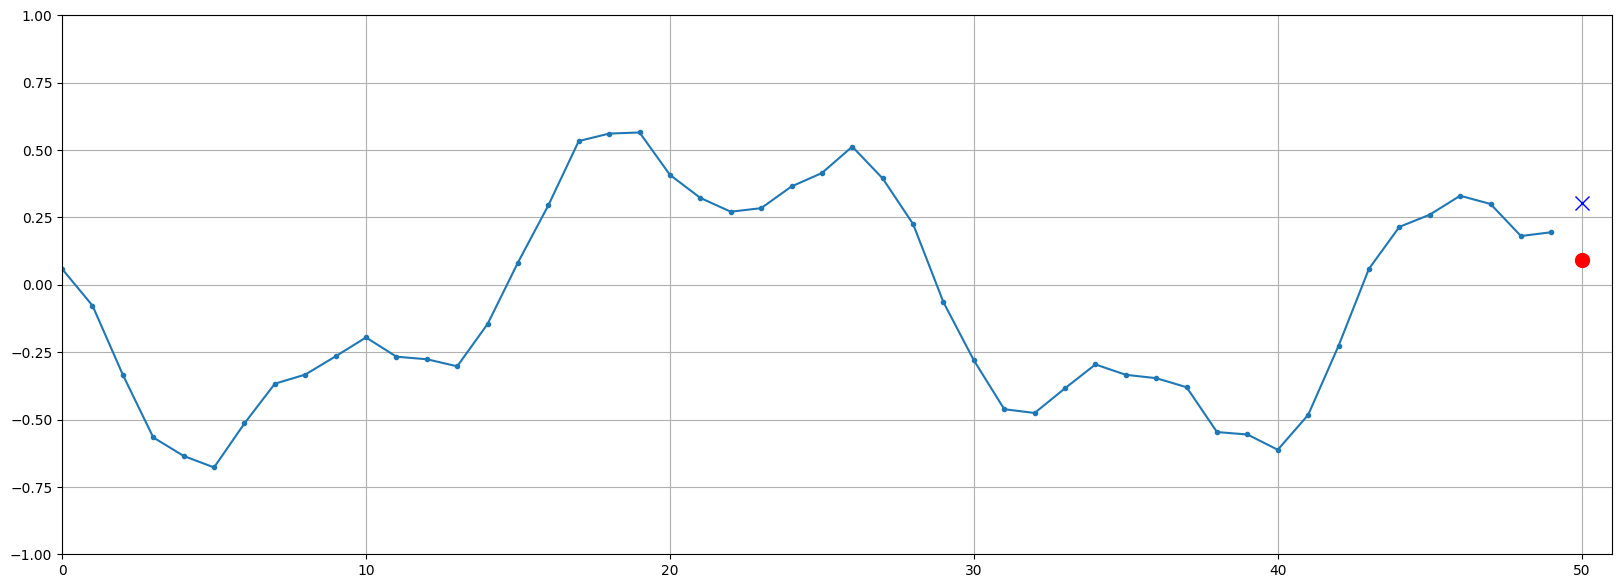

In [89]:
n = 5
plt.figure(figsize=[20,7])
plot_series2(X_test[n,:,0], y_test[n,:,0], y_pred[n,:].cpu().numpy())


## Input size de 2 dimensiones

Se incorpora la derivada como un feature adicional (le damos más profundidad a la input)

In [90]:
# Funcion para generar base de datos de señales con el feature de derivada
def generate_time_series_derivada(batch_size, n_steps, n_future, derivada=False):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    if derivada:
      fc_ser = series[:,0]
      serie_dev = np.diff(series, axis=1, prepend=fc_ser[:,None])
      series = np.stack([series, serie_dev], axis=-1)
    else:
      series = series[..., np.newaxis]
    return series.astype(np.float32)


In [91]:
# probamos el feature si funciona
serie_derivada = generate_time_series_derivada(100, 50, 1, derivada=True)
print('batch x largo x nro features(si paso mas de 1 feature en cada tiempo)')
serie_derivada.shape

batch x largo x nro features(si paso mas de 1 feature en cada tiempo)


(100, 51, 2)

In [92]:
# para los y deseados, solamente queremos hacer regresión sobre la señal
# (no su derivada). Entonces en y solo sacamos la 1ra muestra de la dimensión
# profundidad

n_steps = 50
n_future = 1
series = generate_time_series_derivada(10000, n_steps, n_future, derivada=True)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:, 0]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 2) (7000, 1)
X and y Valid shape
(2000, 50, 2) (2000, 1)
X and y Test shape
(1000, 50, 2) (1000, 1)


In [93]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader_dev = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

### RRN con input_size = 2 para tomar la derivada del input como input

In [94]:
rnn_dev = RNN(input_size=2, hidden_size=5, num_layers=1)
rnn_dev

RNN(
  (rnn): RNN(2, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [95]:
imp_param(rnn_dev)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 2])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 5])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
51
------------------------------------------------------------------------------------


In [96]:
# veamos que arroja nuestra rnn

entrada = torch.rand(20,2)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([[0.5263, 0.1713],
        [0.7379, 0.3731],
        [0.0422, 0.3262],
        [0.1013, 0.6623],
        [0.0049, 0.8129],
        [0.9865, 0.6233],
        [0.4708, 0.7107],
        [0.2553, 0.0564],
        [0.7637, 0.0895],
        [0.0273, 0.9726],
        [0.1689, 0.2652],
        [0.0445, 0.0661],
        [0.9573, 0.4675],
        [0.6651, 0.6960],
        [0.1931, 0.0939],
        [0.1534, 0.4201],
        [0.4453, 0.3498],
        [0.5188, 0.0435],
        [0.3583, 0.5805],
        [0.0870, 0.7908]])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 2])

In [97]:
# paso la entrada a la red
salida = rnn_dev(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.3879]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [98]:
fit(rnn_dev, dataloader_dev)

epoch numero:  0


valid_loss 0.14132: 100%|██████████| 32/32 [00:00<00:00, 176.12it/s]


epoch numero:  1


valid_loss 0.03970: 100%|██████████| 32/32 [00:00<00:00, 174.99it/s]


epoch numero:  2


valid_loss 0.01147: 100%|██████████| 32/32 [00:00<00:00, 179.33it/s]


epoch numero:  3


valid_loss 0.00938: 100%|██████████| 32/32 [00:00<00:00, 174.63it/s]


epoch numero:  4


valid_loss 0.00797: 100%|██████████| 32/32 [00:00<00:00, 186.53it/s]


epoch numero:  5


valid_loss 0.00708: 100%|██████████| 32/32 [00:00<00:00, 170.06it/s]


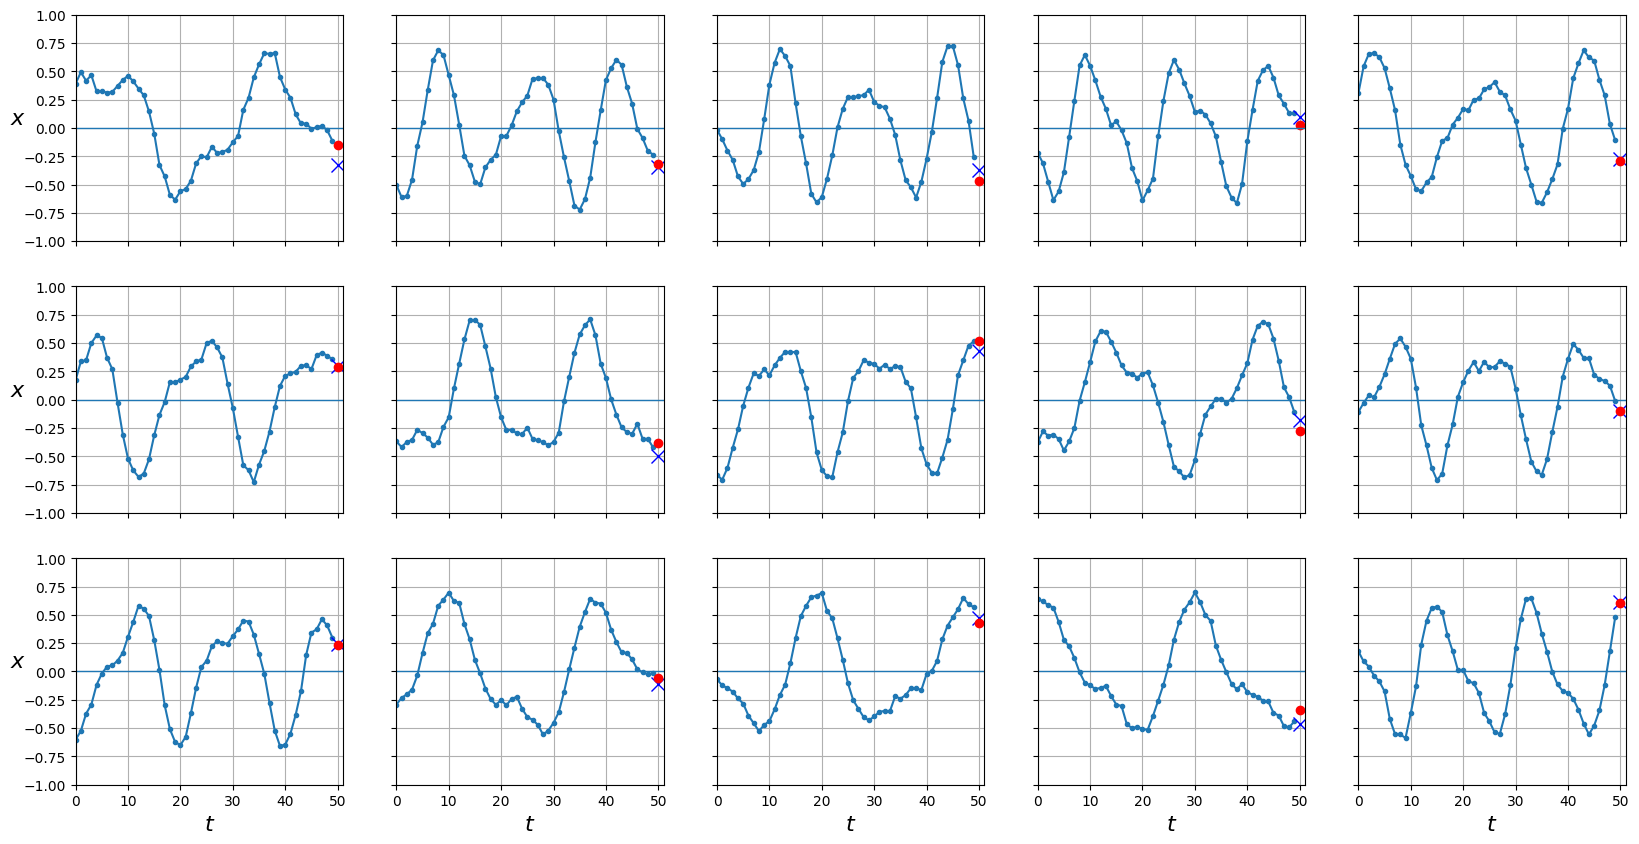

Error cuadratico medio de la estimación final: 


0.007147485

In [99]:
y_pred = predict(rnn_dev, dataloader_dev['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

### comparamos la misma arq de red, pero sin el feature "derivada"

Para esto tenemos que armar una nueva arq con input_size = 1 y conservar el resto de hiperparámetros.

In [100]:
rnn_sin_dev = RNN(input_size=1, hidden_size=5, num_layers=1)
rnn_sin_dev

RNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [101]:
imp_param(rnn_sin_dev)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 5])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
46
------------------------------------------------------------------------------------


In [102]:
fit(rnn_sin_dev, dataloader)

epoch numero:  0


valid_loss 0.15215: 100%|██████████| 32/32 [00:00<00:00, 177.33it/s]


epoch numero:  1


valid_loss 0.11308: 100%|██████████| 32/32 [00:00<00:00, 174.08it/s]


epoch numero:  2


valid_loss 0.05576: 100%|██████████| 32/32 [00:00<00:00, 174.65it/s]


epoch numero:  3


valid_loss 0.02471: 100%|██████████| 32/32 [00:00<00:00, 191.25it/s]


epoch numero:  4


valid_loss 0.01518: 100%|██████████| 32/32 [00:00<00:00, 188.97it/s]


epoch numero:  5


valid_loss 0.01268: 100%|██████████| 32/32 [00:00<00:00, 179.53it/s]


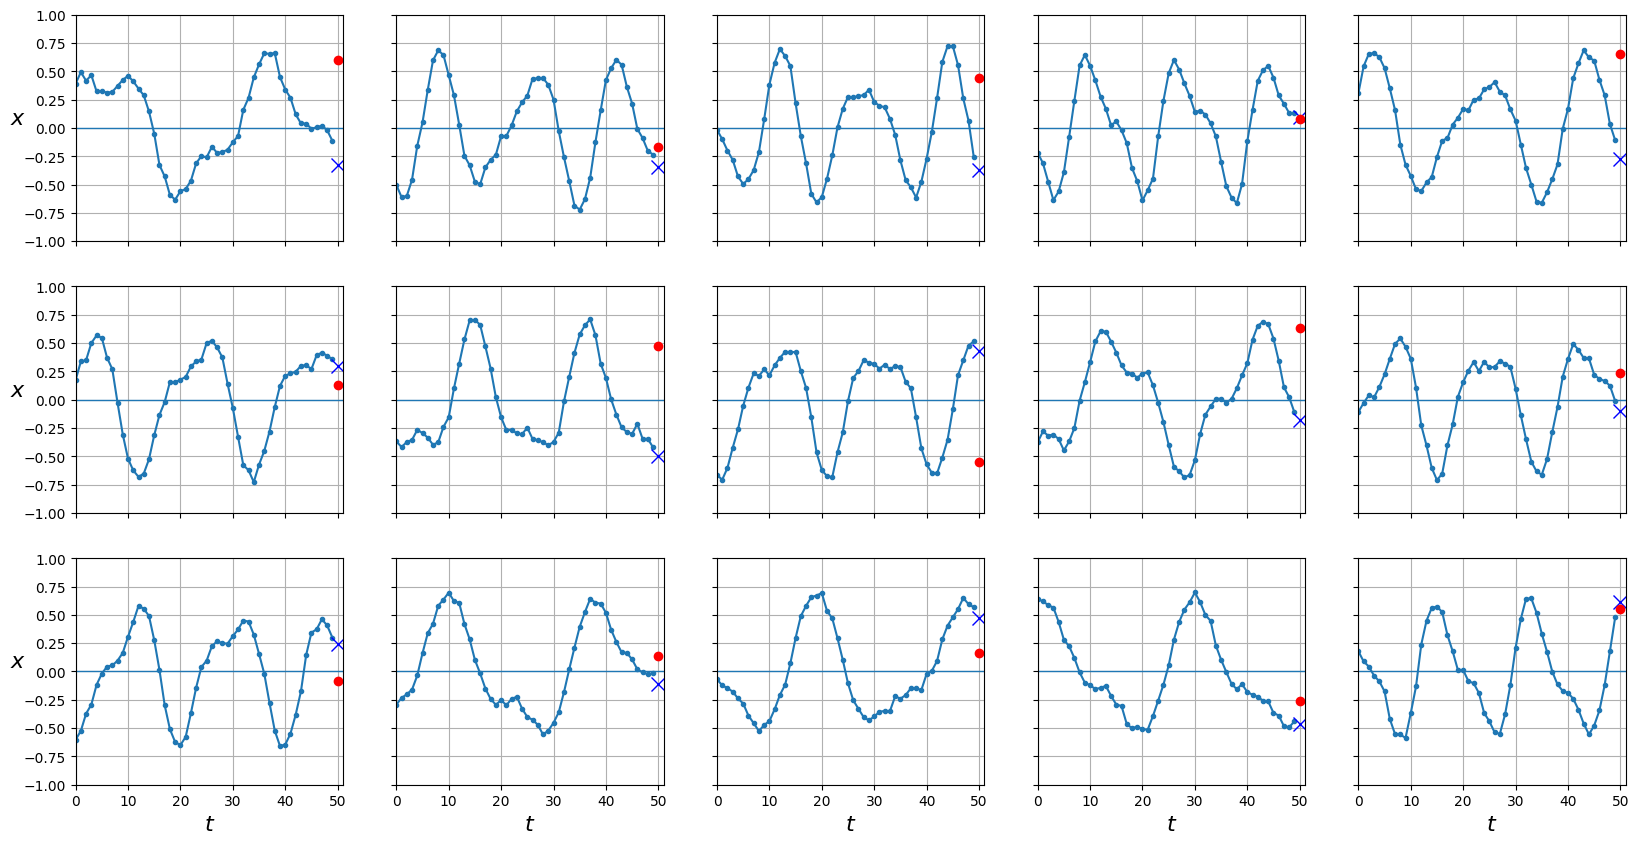

Error cuadratico medio de la estimación final: 


0.2822701

In [103]:
y_pred = predict(rnn_sin_dev, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))